In [1]:
import os
import sys

from sklearn.metrics import r2_score
ecpy_path = '../../../ecpy/'
sys.path.insert(0, os.path.abspath(ecpy_path))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
# from curate_kcat import *

# from multiprocessing import Process,cpu_count,Manager



In [2]:

dffrac_pro = pd.read_csv('../Results/protein_abundance_go_slim_level_uniq_asc.csv', index_col=0)

dffrac_mRNA = pd.read_excel('../proteomics/mRNA_abundance_go_slim-20201124.xlsx', sheet_name='mRNA', index_col=0,
                            header=0)
dftot = pd.read_csv('../proteomics/total_protein_abandance_mean.csv', index_col=0)

/Users/lhao/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lhao/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lhao/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lhao/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


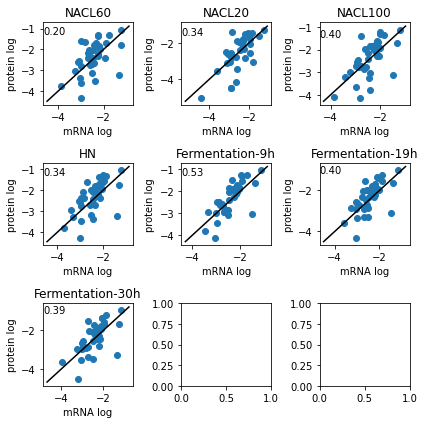

In [3]:
# dffrac_pro
# dffrac_mRNA

fig, axs = plt.subplots(3, 3, figsize=(6, 6))
lim = [-1, 9]

for i, cond_id in enumerate(dftot.index):
    if cond_id == 'MU':
        continue
    ax_i = axs[i // 3, i % 3]
    x_i = np.log10(dffrac_mRNA['MassFrac_' + cond_id])
    y_i = np.log10(dffrac_pro['MassFrac_' + cond_id])
    ax_i.scatter(x_i, y_i)
    # r2_score(x_i.values, y_i.values)
    lim = [min(ax_i.get_ylim()[0], ax_i.get_xlim()[0]), max(ax_i.get_ylim()[1], ax_i.get_xlim()[1])]

    ax_i.plot(lim, lim, 'black')

    y_i_r = y_i.values
    x_i_r = x_i.values
    y_i_r = y_i.values[(y_i.values > -5) & (x_i.values > -5)]
    x_i_r = x_i.values[(y_i.values > -5) & (x_i.values > -5)]
    ax_i.text(ax_i.get_xlim()[0], ax_i.get_ylim()[1] * 1.8, "%.2f" % r2_score(y_i_r, x_i_r))

    ax_i.set_xlabel('mRNA log')
    ax_i.set_ylabel('protein log')
    ax_i.set_title(cond_id)
plt.tight_layout()
plt.show()

coeff_means: 1.651567 
coeff_std: 0.071373


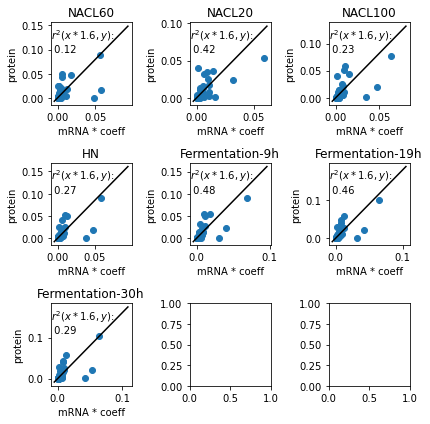

In [4]:
# y = 1.6x —+ stv
# dffrac_mRNA
coeff_dic = {'NACL60': 1.586596438, 'NACL20': 1.572338571, 'NACL100': 1.635750178,
             'HN': 1.702987161, 'Fermentation-9h': 1.6792188,
             'Fermentation-19h': 1.787498847, 'Fermentation-30h': 1.596578543, }

coeff_means = np.mean(list(coeff_dic.values()))
coeff_std = np.std(list(coeff_dic.values()))
print('coeff_means: %f \ncoeff_std: %f' % (coeff_means, coeff_std))

fig, axs = plt.subplots(3, 3, figsize=(6, 6))
lim = [-1, 9]

for i, cond_id in enumerate(dftot.index):
    if cond_id == 'MU':
        continue
    ax_i = axs[i // 3, i % 3]
    x_i = dffrac_mRNA['MassFrac_' + cond_id]
    y_i = dffrac_pro['MassFrac_' + cond_id]
    ax_i.scatter(x_i, y_i)

    lim = np.array([min(ax_i.get_ylim()[0], ax_i.get_xlim()[0]), max(ax_i.get_ylim()[1], ax_i.get_xlim()[1])])

    ax_i.plot(lim, lim * coeff_dic[cond_id], 'black')
    ax_i.text(ax_i.get_xlim()[0], ax_i.get_ylim()[1] * 0.6,
              "$r^2(x*1.6,y)$:\n %.2f" % r2_score(x_i.values * coeff_dic[cond_id], y_i.values))

    ax_i.set_xlabel('mRNA * coeff')
    ax_i.set_ylabel('protein')
    ax_i.set_title(cond_id)
plt.tight_layout()
plt.show()





### umap

In [5]:

sns.set(style='white', context='notebook', rc={'figure.figsize': (14, 10)})

pro_result_df = pd.read_csv('../Results/FVA_result_df_pro_.tsv', sep='\t', index_col=0, )
mRNA_result_df = pd.read_csv('../Results/FVA_result_df_mRNA_.tsv', sep='\t', index_col=0, )
pro_result_df.columns = pro_result_df.columns + '_pro'
mRNA_result_df.columns = mRNA_result_df.columns + '_mRNA'


def upam_draw(result_df):
    result_df.head()

    cond_list = [i.split('_')[1] for i in result_df.columns]

    cond_set = list(set(cond_list))
    cond_dic = {cond_set[i]: i for i in range(len(cond_set))}
    color_list = np.array([sns.color_palette()[cond_dic[i]] for i in cond_list])

    type_list = np.array([i.split('_')[-1] for i in result_df.columns])
    pro_type_list = type_list == 'pro'
    mRNA_type_list = type_list == 'mRNA'

    reducer = umap.UMAP()
    data = result_df.values.T

    embedding = reducer.fit_transform(data)
    embedding.shape

    plt.scatter(
        embedding[pro_type_list, 0],
        embedding[pro_type_list, 1],
        c=color_list[pro_type_list],
        marker='o'
    )

    plt.legend
    plt.scatter(
        embedding[mRNA_type_list, 0],
        embedding[mRNA_type_list, 1],
        c=color_list[mRNA_type_list],
        marker='^'
    )

    plt.legend(['pro', 'mRNA'])
    plt.show()


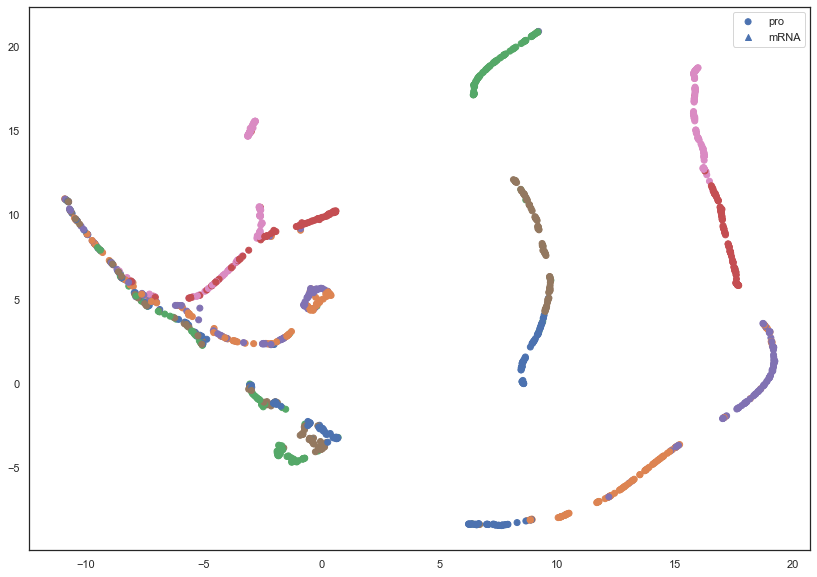

In [6]:
result_df = pro_result_df.dropna()
upam_draw(result_df)

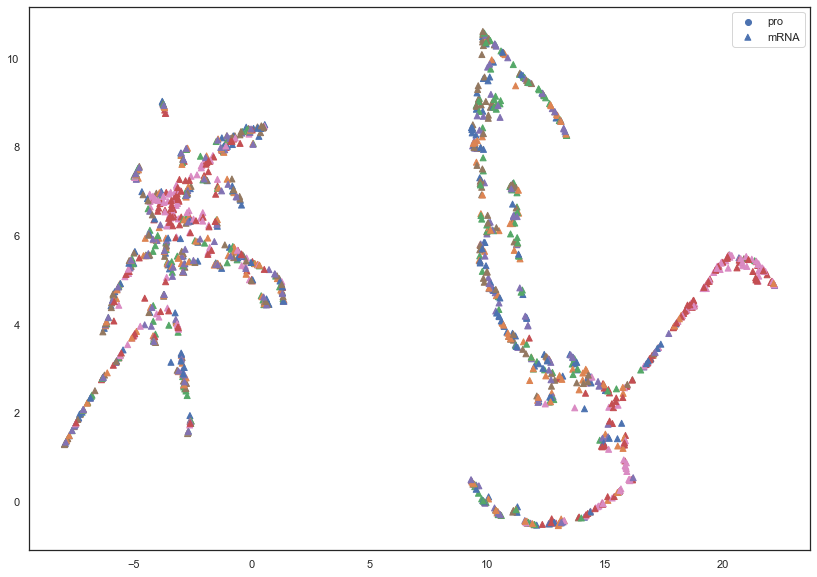

In [7]:
result_df = mRNA_result_df.dropna()
upam_draw(result_df)

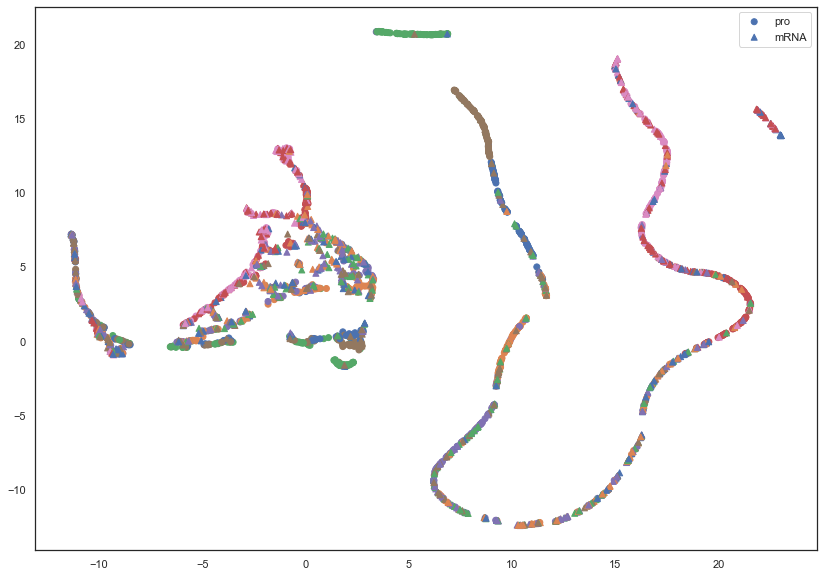

In [8]:
result_df = pro_result_df.merge(mRNA_result_df, how='outer', left_index=True, right_index=True)
result_df = result_df.dropna()
upam_draw(result_df)

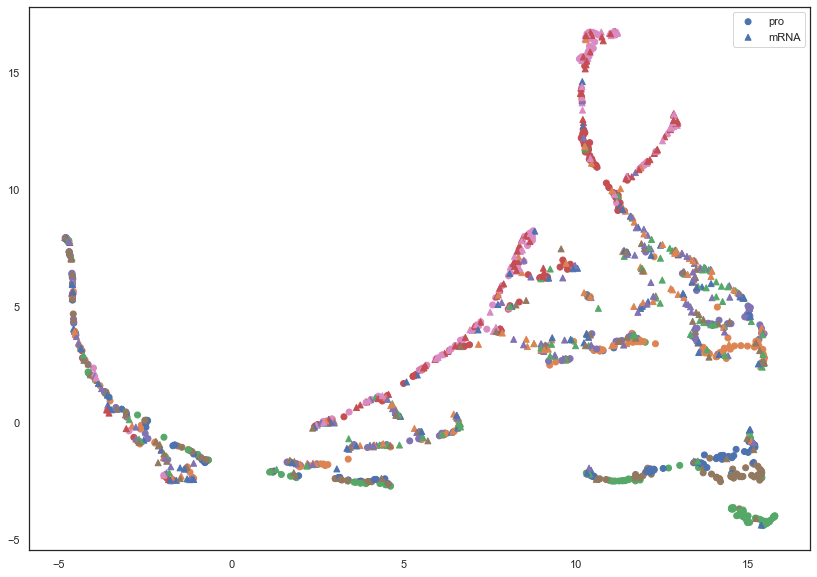

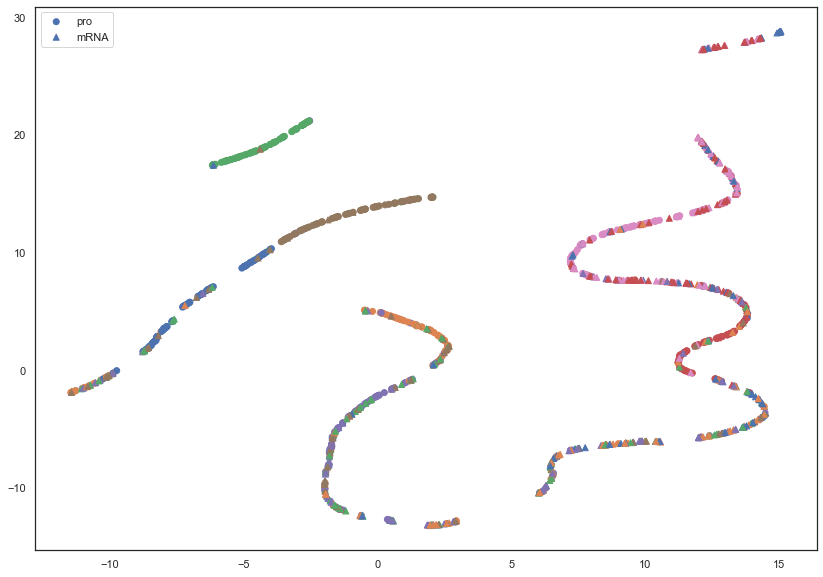

In [9]:
result_df = pro_result_df.merge(mRNA_result_df, how='outer', left_index=True, right_index=True)
result_df = result_df.dropna()
result_df_max = result_df[[i for i in result_df.columns if 'max' in i]]
result_df_min = result_df[[i for i in result_df.columns if 'min' in i]]
upam_draw(result_df_max)

upam_draw(result_df_min)
